#  Использование предобученных моделей для классификации изображений

* Deep Learning with PyTorch (2020) Авторы: Eli Stevens, Luca Antiga, Thomas Viehmann 
* https://pytorch.org/vision/0.16/transforms.html#v2-api-reference-recommended
* https://pytorch.org/vision/main/generated/torchvision.datasets.ImageFolder.html
* https://pytorch.org/vision/stable/models.html
* https://albumentations.ai/docs/getting_started/image_augmentation/

In [1]:
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
import torchvision
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn.functional as F
from tqdm.auto import tqdm
from sklearn import metrics
import seaborn as sns
import pandas as pd

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(DEVICE)

cuda


In [2]:
def calculate_accuracy(predictions, grs):
    """Multiclass problem accuracy"""
    predictions = torch.softmax(predictions, dim=1)
    predictions = torch.argmax(predictions, dim=1)
    return (torch.sum(predictions == grs) / len(grs)).item()

In [3]:
import torch
from tqdm import tqdm

def classification_loop(train_loader, test_loader, model, criterion, optimizer, epochs, device="cuda"):
    """Training loop for c-class classification problem with optimized CUDA memory management."""
    train_loss_history = []
    test_loss_history = []

    for epoch in tqdm(range(epochs)):
        train_loss = 0.0
        train_acc = 0.0
        test_loss = 0.0
        test_acc = 0.0

        # Training phase
        model.train()
        for x_batch, y_batch in train_loader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            predictions = model(x_batch)
            loss = criterion(predictions, y_batch)
            loss.backward()
            optimizer.step()
            
            # Accumulate losses and accuracy
            train_loss += loss.item()
            train_acc += calculate_accuracy(predictions, y_batch)

            # Delete unnecessary variables and clear cache after each batch
            del x_batch, y_batch, predictions, loss
            torch.cuda.empty_cache()

        train_loss /= len(train_loader)
        train_acc /= len(train_loader)
        train_loss_history.append(train_loss)

        # Evaluation phase (test)
        with torch.inference_mode():
            model.eval()
            for x_test_batch, y_test_batch in test_loader:
                x_test_batch, y_test_batch = x_test_batch.to(device), y_test_batch.to(device)
                test_predictions = model(x_test_batch)
                test_loss += criterion(test_predictions, y_test_batch).item()
                test_acc += calculate_accuracy(test_predictions, y_test_batch)

                # Delete unnecessary variables and clear cache after each batch
                del x_test_batch, y_test_batch, test_predictions
                torch.cuda.empty_cache()

        test_loss /= len(test_loader)
        test_acc /= len(test_loader)
        test_loss_history.append(test_loss)

        print(f"Epoch: {epoch+1} | Train loss: {train_loss:.4f} | Train acc: {train_acc:.4f} | "
              f"Test loss: {test_loss:.4f} | Test acc: {test_acc:.4f}")

    return train_loss_history, test_loss_history


Модель `vgg16` и предобученные веса `IMAGENET1K_V1`. В последствии вывели на экран структуру модели, количество слоев и количество настраиваемых (`requires_grad==True`) параметров модели. 


In [5]:
from torchvision import models

model = models.vgg16(pretrained=True)
model

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /tmp/xdg_cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:04<00:00, 111MB/s]  


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [6]:
num_layers = sum(1 for _ in model.features)  
num_layers += sum(1 for _ in model.classifier)
num_layers

38

In [7]:
num_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
num_trainable_params

138357544

датасет `CatBreeds` на основе данных из архива `cat_breeds_4.zip`. 

К обучающему датасету применили следующее преобразование: привели картинку к размеру 256x256, затем обрезали по центру с размером 224х224, затем перевели изображения в тензор и нормализовали значения интенсивности пикселей (`mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)`).

К тестовому датасету применили преобразование `VGG16_Weights.IMAGENET1K_V1.transforms`.


In [4]:
from torchvision.models import VGG16_Weights
import zipfile
import os
from tqdm import tqdm

transform = transforms.Compose([
    transforms.Resize((256, 256)), 
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))  # Нормализация
])

test_transforms = VGG16_Weights.IMAGENET1K_V1.transforms()

zip_path = '/home/jupyter/datasphere/project/cat_breeds_4.zip'
extract_path = '/home/jupyter/datasphere/project/'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    for member in tqdm(zip_ref.infolist(), desc="Extracting"):
        zip_ref.extract(member, extract_path)
dataset_folder = os.path.join(extract_path, 'cat_breeds_4')

dataset = datasets.ImageFolder(root=dataset_folder, transform=transform)

train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

test_dataset.dataset.transform = test_transforms

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


len(train_dataset), len(test_dataset)

Extracting: 100%|██████████| 4005/4005 [00:08<00:00, 484.98it/s]


(3200, 800)

Далее замораживаем все веса модели из предыдущего пункта. Заменили последний слой `Linear` классификатора на новый слой, соответствующий задаче. После изменения последнего слоя вывели на экран количество настраиваемых (`requires_grad==True`) параметров модели. Решили задачу, используя модель с замороженными весами и изменнным последним слоем. 

Далее строим график изменения значения функции потерь на обучающем множестве в зависимости от номера эпохи, графики изменения метрики accuracy на обучающем и тестовом множестве в зависимости от эпохи. Вывели accuracy

In [9]:
for param in model.parameters(): #замораживаем веса
    param.requires_grad = False

In [10]:
model.classifier[6] = nn.Linear(in_features=4096, out_features=4)
num_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
num_trainable_params

16388

In [13]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.classifier[6].parameters(), lr=0.001)
model = models.vgg16(pretrained=True).to(DEVICE)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [15]:
num_classes = len(train_loader.dataset.dataset.classes)
print("Количество классов:", num_classes)
model.classifier[6] = nn.Linear(4096, num_classes)


Количество классов: 4


In [17]:
model = model.to(DEVICE)
train_loss_history, test_loss_history = classification_loop(
    train_loader, test_loader, model, criterion, optimizer, 10
)

 10%|█         | 1/10 [00:40<06:05, 40.65s/it]

Epoch: 1 | Train loss: 1.4361 | Train acc: 0.2838 | Test loss: 1.3677 | Test acc: 0.3300


 20%|██        | 2/10 [01:16<05:01, 37.72s/it]

Epoch: 2 | Train loss: 1.4385 | Train acc: 0.2831 | Test loss: 1.3677 | Test acc: 0.3300


 30%|███       | 3/10 [01:52<04:20, 37.15s/it]

Epoch: 3 | Train loss: 1.4255 | Train acc: 0.3053 | Test loss: 1.3677 | Test acc: 0.3300


 40%|████      | 4/10 [02:28<03:39, 36.57s/it]

Epoch: 4 | Train loss: 1.4373 | Train acc: 0.2853 | Test loss: 1.3677 | Test acc: 0.3300


 50%|█████     | 5/10 [03:04<03:01, 36.32s/it]

Epoch: 5 | Train loss: 1.4254 | Train acc: 0.3056 | Test loss: 1.3677 | Test acc: 0.3300


 60%|██████    | 6/10 [03:40<02:24, 36.22s/it]

Epoch: 6 | Train loss: 1.4311 | Train acc: 0.2825 | Test loss: 1.3677 | Test acc: 0.3300


 70%|███████   | 7/10 [04:16<01:48, 36.06s/it]

Epoch: 7 | Train loss: 1.4250 | Train acc: 0.2981 | Test loss: 1.3677 | Test acc: 0.3300


 80%|████████  | 8/10 [04:52<01:12, 36.04s/it]

Epoch: 8 | Train loss: 1.4305 | Train acc: 0.2938 | Test loss: 1.3677 | Test acc: 0.3300


 90%|█████████ | 9/10 [05:27<00:35, 35.96s/it]

Epoch: 9 | Train loss: 1.4234 | Train acc: 0.3075 | Test loss: 1.3677 | Test acc: 0.3300


100%|██████████| 10/10 [06:03<00:00, 36.37s/it]

Epoch: 10 | Train loss: 1.4361 | Train acc: 0.2869 | Test loss: 1.3677 | Test acc: 0.3300


Заморозим все сверточные слои, кроме последнего. Сравниваем качество полученного решения и решения из предыдущего пунтка, а также время, затраченное на обучения моделей. 

In [21]:
from torchvision.models import vgg16, VGG16_Weights
model = vgg16(weights=VGG16_Weights.IMAGENET1K_V1).to(DEVICE)

for name, param in model.features.named_parameters():
    param.requires_grad = False 
    if "30" in name or "31" in name or "32" in name:
        param.requires_grad = True
        

num_classes = len(train_loader.dataset.dataset.classes)
model.classifier[6] = nn.Linear(4096, num_classes).to(DEVICE)

optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.0001)

In [23]:

train_loss_history, test_loss_history = classification_loop(
    train_loader, test_loader, model, criterion, optimizer, 4
)

 25%|██▌       | 1/4 [00:27<01:22, 27.63s/it]

Epoch: 1 | Train loss: 0.0407 | Train acc: 0.9872 | Test loss: 0.8406 | Test acc: 0.7650


 50%|█████     | 2/4 [00:55<00:55, 27.69s/it]

Epoch: 2 | Train loss: 0.0223 | Train acc: 0.9912 | Test loss: 0.9562 | Test acc: 0.7875


 75%|███████▌  | 3/4 [01:22<00:27, 27.66s/it]

Epoch: 3 | Train loss: 0.0294 | Train acc: 0.9900 | Test loss: 1.1981 | Test acc: 0.7675


100%|██████████| 4/4 [01:50<00:00, 27.67s/it]

Epoch: 4 | Train loss: 0.0188 | Train acc: 0.9956 | Test loss: 1.0064 | Test acc: 0.7963


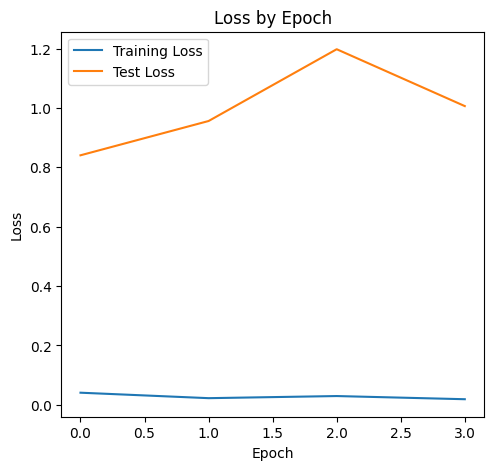

In [24]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_loss_history, label='Training Loss')
plt.plot(test_loss_history, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss by Epoch')
plt.legend()

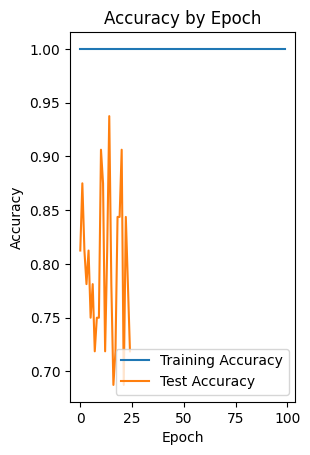

In [25]:
import warnings
warnings.filterwarnings('ignore')
device = "cuda" if torch.cuda.is_available() else "cpu"
train_acc_history = [calculate_accuracy(torch.tensor(model(x_batch.to(device)).detach().cpu()), y_batch)
                     for x_batch, y_batch in train_loader]
test_acc_history = [calculate_accuracy(torch.tensor(model(x_batch.to(device)).detach().cpu()), y_batch)
                    for x_batch, y_batch in test_loader]

plt.subplot(1, 2, 2)
plt.plot(train_acc_history, label='Training Accuracy')
plt.plot(test_acc_history, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy by Epoch')
plt.legend()

plt.show()

Расширяем обучающий набор данных при помощи преобразований из `torchvision`, изменяющих изображение (повороты, изменение интенсивности пикселей, обрезание и т.д.). При оценке модели на тестовой выборке данные преобразования применяться не должны. 
Модель создается заново

In [6]:
from torchvision.models import vgg16, VGG16_Weights
model = vgg16(weights=VGG16_Weights.IMAGENET1K_V1).to(DEVICE)

for name, param in model.named_parameters():
    param.requires_grad = False
    
for name, param in list(model.features.named_parameters())[-8:]:  
    param.requires_grad = True
    
for name, param in model.classifier.named_parameters():
    param.requires_grad = True
    
num_classes = len(train_loader.dataset.dataset.classes)
model.classifier[6] = nn.Linear(4096, num_classes).to(DEVICE)


Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /tmp/xdg_cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:03<00:00, 144MB/s]  


In [7]:
transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
])

test_transforms = VGG16_Weights.IMAGENET1K_V1.transforms()
dataset = datasets.ImageFolder(root=dataset_folder, transform=transform)

train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

test_dataset.dataset.transform = test_transforms

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [8]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.0001)


In [ ]:

train_loss_history, test_loss_history = classification_loop(
    train_loader, test_loader, model, criterion, optimizer, 4
)

 25%|██▌       | 1/4 [00:34<01:43, 34.51s/it]

Epoch: 1 | Train loss: 0.6347 | Train acc: 0.7406 | Test loss: 0.4653 | Test acc: 0.8213


 50%|█████     | 2/4 [01:03<01:02, 31.34s/it]

Epoch: 2 | Train loss: 0.2969 | Train acc: 0.8781 | Test loss: 0.5181 | Test acc: 0.8125
